In [9]:
%%capture
!pip install dimod
import dimod

# Modelo de Ising

Queremos mapear  un problema de optimización a un  sistema físico. El [modelo de Ising](https://en.wikipedia.org/wiki/Ising_model) es el modelo más básico para hacer esta conexión. Es un modelo sumamente estudiado y usado de benchmark en mecánica estadística y estudio de transiciones de fase. La idea básica es sencilla.

Si tenemos 2 imanes paralelos, estos van a tender a antialinearse: uno tendrá su polo norte apuntando hacia arriba, y el segundo hacia abajo. Podemos pensar en dos variables binarias, $\sigma_1$ y $\sigma_2$. Si el polo norte apunta hacia arriba tomamos el valor +1, y si apunta hacia abajo tomamos -1. Para abstraernos de los imanes, hablamos de [spines](https://en.wikipedia.org/wiki/Spin_(physics)). En esta configuración estable, el producto es $-1$:

$$ \sigma_1\sigma_2=-1$$

Podemos pensar que esta es la energía del sistema: la mínima energía posible se conoce como energía fundamental. Hay 2 configuraciones que alcanzan este óptimo:  $\sigma_1=+1, \sigma_2=-1$, y $\sigma_1=-1, \sigma_2=+1$.

Si agregamos más imanes al sistema, tenemos que sumar la interacción de a pares al total de energía. El operador que define la energía total del sistema se llama Hamltoniano, y se denota $H$. Si tenemos $N$ imanes en una linea recta,

$$ H=\sum_{i=1}^{N-1} \sigma_i \sigma_{i+1}$$

Asumimos para simplificar que imanes lejanos no interactúan (no hay términos $\sigma_i\sigma_{i+2}$). En general, las interacciones dependen del layout de los spines. En general podemos pensar en un grafo describiendo la conectividad de las interacciones  

$$ H=\sum_{<i,j>} \sigma_i \sigma_{j}$$

donde  $<i,j>$ denota  vecinos cercanos, pero depende de nosotros definir que son los vecinos cercanos.

Podemos agrega ahora un poco más de complejidad. Supongamos que las distancias entre pares no son constantes. Es decir, algunos pares interactuan más fuertemente que otros. Para expresar esto agregamos un parámetro que describe la intensidad de la interacción:

$$ H=-\sum_{<i,j>} J_{ij} \sigma_i \sigma_{j}$$

donde  $J_{ij}$ es un número real. Agregamos un signo negativo al Hamiltoniano por convención. Si los spines son antiferromagnetico (los imanes comunes), los valores de $J_{ij}$ son negativos, cancelando el signo y recuperando  $\sigma_i\sigma_j=-1$ en la configuración óptima.

En general,  $J_{ij}$ puede tomar valores tanto negativos como positivos. La naturaleza va a buscar la configuración que minimiza la energía. La clave de todo esto es que la naturaleza es en si misma una máquina de minimizar/optimizar.


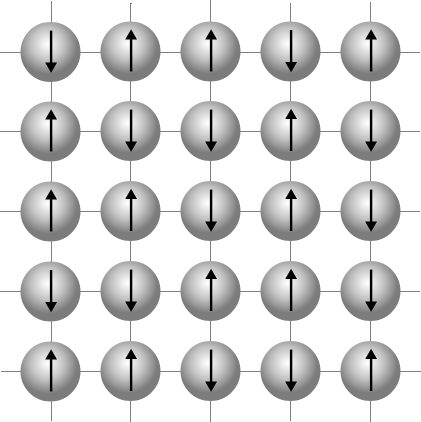

In [10]:
def calculate_energy(J, σ):
    return -sum(J_ij*σ[i]*σ[i+1] for i, J_ij in enumerate(J))

In [11]:
J = [1.0, -1.0]
σ = [+1, -1, +1]
calculate_energy(J, σ)

-0.0

Podemos ver las configuraciones posibles con sus respectivas energías

In [12]:
import itertools
for σ in itertools.product(*[{+1,-1} for _ in range(3)]):
    print(calculate_energy(J, σ), σ)

-0.0 (1, 1, 1)
-2.0 (1, 1, -1)
-0.0 (1, -1, 1)
2.0 (1, -1, -1)
2.0 (-1, 1, 1)
-0.0 (-1, 1, -1)
-2.0 (-1, -1, 1)
-0.0 (-1, -1, -1)


El caso general agrega un campo externo. Por ejemplo, agregar un campo magnético externo que afecte todos los imanes. Modelamos esto con un término lineal en el Hamiltoniano:

$$ H=-\sum_{<i,j>} J_{ij} \sigma_i \sigma_{j} - \sum_i h_i \sigma_i$$

donde  $h_i$ es la intensidad del campo externo (este término debería resonarle a los que sepan de machine learning, ya que es muy similar al término de renormalización de la función coste). Esta es la descripción completa del *modelo clásico de Ising*. El Hamiltoniano, que describe la  energía, no deja de ser un problema de minimización. El problema equivalente en ciencias de la computación es el Quadratic Unconstrained Binary Optimization (QUBO), donde la única diferencia es que las variables toman los valores en $\{0, 1\}$ (shift constante). Los problemas QUBO son en general NP, es decir que no se conoce algoritmo eficiente en tiempo polinómico. La estrategia suele ser realizar una búsqueda exhaustiva como hicimos acá arriba, que toma en principio una cantidad exponencial de pasos en el número de sitios.

Dijimos que la naturaleza busca minimizar la configuración de energía. ¿Pero como se mapea la complejidad computacional a complejidad física? Si la diferencia de energía entre el estdo fundamental y el siguiente estado de energía (primer excitado) es pequeña, pero el costo energético de ir de uno al otro es alto, podemos caer en mínimos locales.

Si comenzamos en una configuración aleatoria, podemos quedar trabados en el mínimo local que no es absoluto. Esto es lo que sucede, por ejemplo, en los metales cuando se los enfría demasiado rápido: cristalizan con inperfeccciones y no tiene las propiedades deseadas. En metalurgia esto se arregla usando un proceso conocido como *annealing*: aumentando la temperatura, las chances de saltear la barrera de potencial aumentan y la estructura cristalina se reconfigura. Si la barrera es alta y la diferencia de energía pequeña, es más dificil lograr esto. En este caso tenemos un problema dificil para el mismísimo sistema físico.

Este mecanismo metalúrgico inspiró heurísticamente un algoritmo llamado *simulated annealing*. Se define una temperatura y se la disminuye de forma controlada.

In [13]:
J = {(0, 1): 1.0, (1, 2): -1.0}
h = {0:0, 1:0, 2:0}

# Creamos el modelo 
model = dimod.BinaryQuadraticModel(h, J, 0.0, dimod.SPIN)
sampler = dimod.SimulatedAnnealingSampler()
response = sampler.sample(model, num_reads=10)
[solution.energy for solution in response.data()].count(-2)

10

# Computación adiabática

Cuando hablamos de computación cuántica, hablamos en realidad de varios paradigmas diferentes. El más común es el modelo de compuertas que ya discutimos. En este caso, aplicamos gates a registros de qubits para realizar transformaciones arbitrarias sobre estados cuánticos.

El segundo paradigma más común es quantum annealing. Este paradigma suele conocerce como computación cuántica adiabática, aunque es ligeramente diferente. Quantum annealing resuleve problemas específicos, no pretende universalidad, lo que lo hace más fácil de escalear. Actualmente estos sistemas cuentan con hasta 5640 qubits superconductores (D-Wave, 2020), comparados con los menos de 100 del gate-model. Hay implementaciones también con modelos ópticos.

El gate-model suele ser más sencillo de entender, ya que es la generalización de la computación digital. Para entender annealing, es necesario entender física. Quantum annealing sirvió de inspiración para muchos algoritmos del gate-model (VQE por ejemplo) con lo cual es importante comprenderlo, aunque no nos interese trabajar directamente en este modelo.



### Evolución unitaria y Hamiltonianos

Introducimos el Hamiltoniano como un objeto que describe la energía de un sistema clásico o cuántico. Es sumamente importante porque está directamente vinculado con la evolución temporal mediante la ecuación de Schrödinger

$$
i\hbar {\frac {d}{dt}}|\psi(t)\rangle = H|\psi(t)\rangle,
$$

donde $\hbar$ es la constante de Planck reducida. Dijimos que los estados cuánticos evolucionan con un operador unitario. Si resolvemos la ecuación de Schrödinger tenemos:

$$|\psi(t)\rangle = U(t)|\psi(0)\rangle$$

con  $U = \exp(-i Ht/\hbar)$. Aquí usamos que el Hamiltoniano no depende del tiempo. Cada unitaria tiene un Hamiltoniano correspondiente. 

La ecuación de arriba toma esa forma cuando el estado depende del tiempo. Muchas veces, podemos usar la ecuación independiente del tiempo, que relaciona más claramente el Hamiltoniano con la energía del sistema:

 $$
 H|\psi \rangle =E|\psi \rangle,
$$

donde $E$ es la energía total del sistema.

### El teorema adibático y computación cuántica adiabática



La idea de un proceso adiabático es cambiar lo suficientemente lento como para que el sistema pueda adeptarse comodamente a su nueva configuración. Por ejemplo, en un sistema cuántico, comentazamos con un Hamiltoniano $H_0$ y lentamente cambiamos hacia otro Hamiltoniano $H_1$. Por ejemplo, si cambiamos linealmente con el tiempo, tenemos:

$$
H(t) = (1-t) H_0 + t H_1,
$$

para  $t\in[0,1]$ en alguna escala temporal. Este Hamiltoniano depende del tiempo, con lo cual resolver Schrödinger es más complejo. El [teorema adiabático]((https://en.wikipedia.org/wiki/Adiabatic_theorem)) dice que si el cambio en un Hamiltoniano dependiente del tiempo es lo suficientemente lento, la dinámica resultante es simple: si comenzamos cerca de un autoestado, el sistema queda cerca al autoestado. Esto implica que, si se cumplen ciertas condiciones, un sistema que comenzó en un estado fundamental queda cerca del estado fundamental.

La diferencia de energía entre el estado fundamental y el primer excitado se conoce como gap ($\Delta$). Si  $H(t)$ tiene un gap positivo para cada $t$ a lo largo de la transición (no hay cruces de niveles) y el cambio sucede lentamente, el sistema se queda en el estado fundamental. Teniendo en cuenta la dependencia del gap con el tiempo  $\Delta(t)$, el límite de velocidad escalea como $1/\min(\Delta(t))^2$.

Con este teorema podemos partir de un Hamiltoniano sencillo y cambiar lentamente al Hamiltoniano deseado.

### Quantum annealing


No es para nada trivial calcular la velocidad límite; de hecho muchas veces es más complicado que resolver el problema original. Además, hay problemas experimentales (decoherencia de qubits, temperatura del entorno, etc). *Quantum annealing* no evoluciona el sistema de forma controlada, sino que facilita el proceso reemplazando los limites de velocidad por dejar evolucionar el sistema con el Hamiltoniano objetivo hacia el estado fundamental (annealing). Luego se observan los resultados y se escoge la confguración de spin con menor energía. No está garantizado que vaya a ser el fundamental. 

Los problemas resolubles con este formato deben poder mapearse a modelos clásicos de Ising. Así como en gate-model, tenemos limitaciones en la cantidad de conectividad. Si la conectividad del mapeo no es realizable con el hardware, es necesario hacer [graph embedding](https://docs.dwavesys.com/docs/latest/c_gs_7.html). 


# Max Cut 

Supongamos que tenemos puntos $\{x_i\}_{i=1}^N$ en un espacio de alta dimensionalidad $\mathbb{R}^d$. ¿Como sabemos que tan cercanos o distantes están? Generemos un dataset

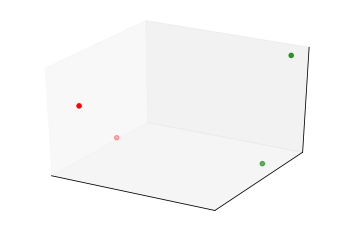

In [14]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline

n_instances = 4
class_1 = np.random.rand(n_instances//2, 3)/5
class_2 = (0.6, 0.1, 0.05) + np.random.rand(n_instances//2, 3)/5
data = np.concatenate((class_1, class_2))
colors = ["red"] * (n_instances//2) + ["green"] * (n_instances//2)
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d', xticks=[], yticks=[], zticks=[])
ax.scatter(data[:, 0], data[:, 1], data[:, 2], c=colors)

Nos construimos una matriz de distancias

In [15]:
import itertools
w = np.zeros((n_instances, n_instances))
for i, j in itertools.product(*[range(n_instances)]*2):
    w[i, j] = np.linalg.norm(data[i]-data[j])

Esta matriz es la matriz de Gram (es tambien un kernel) y contiene información sobre la topología en un espacio de alta dimensionalidad. Basicamente es la matriz cuyos elementos son las distancias entre los datos $i,j$. Podemos pensarlo usando grafos. Estas distancias que aparecen aquí son los pesos de los edges que los conectan. Si la distancia es 0, no están conectados por ningun edge. En general, esto define un grafo con muchos edges. La función elegida como distancia puede cambiarse.

El problema de Max-Cut consiste en hallar los la división del grafo en dos minimizando el peso total de los edges [[1](#1)]. Es un problema NP, pero super natural de mapear a Ising.

Las variables de spin  $\sigma_i \in \{-1, +1\}$ toman valores $\sigma_i = +1$ si la data está en el clase 1 y $\sigma_i = -1$ si está en el clase 2.

El coste del corte es

$$
\sum_{i\in V_1, j\in V_2} w_{ij}
$$

Si el grafo está completamente conectado, podemos usar simetría y expandir como

$$
\frac{1}{4}\sum_{i, j} w_{ij} - \frac{1}{4} \sum_{i, j} w_{ij} \sigma_i \sigma_j
$$
$$
= \frac{1}{4}\sum_{i, j\in V} w_{ij} (1- \sigma_i \sigma_j).
$$                 

Tomando esto negativo, resolvemos el problema directamente con un optimizador cuántico.

In [16]:
import dimod

J, h = {}, {}
for i in range(n_instances):
    h[i] = 0
    for j in range(i+1, n_instances):
        J[(i, j)] = w[i, j]

model = dimod.BinaryQuadraticModel(h, J, 0.0, dimod.SPIN)
sampler = dimod.SimulatedAnnealingSampler()
response = sampler.sample(model, num_reads=10)
print("Energy of samples:")
for solution in response.data():
    print("Energy:", solution.energy, "Sample:", solution.sample)

Energy of samples:
Energy: -2.371140082394475 Sample: {0: -1, 1: -1, 2: 1, 3: 1}
Energy: -2.371140082394475 Sample: {0: -1, 1: -1, 2: 1, 3: 1}
Energy: -2.371140082394475 Sample: {0: 1, 1: 1, 2: -1, 3: -1}
Energy: -2.371140082394475 Sample: {0: -1, 1: -1, 2: 1, 3: 1}
Energy: -2.371140082394475 Sample: {0: 1, 1: 1, 2: -1, 3: -1}
Energy: -2.371140082394475 Sample: {0: 1, 1: 1, 2: -1, 3: -1}
Energy: -2.371140082394475 Sample: {0: -1, 1: -1, 2: 1, 3: 1}
Energy: -2.371140082394475 Sample: {0: -1, 1: -1, 2: 1, 3: 1}
Energy: -2.371140082394475 Sample: {0: 1, 1: 1, 2: -1, 3: -1}
Energy: -2.371140082394475 Sample: {0: 1, 1: 1, 2: -1, 3: -1}


# Referencias


[1] Otterbach, J. S., Manenti, R., Alidoust, N., Bestwick, A., Block, M., Bloom, B., Caldwell, S., Didier, N., Fried, E. Schuyler, Hong, S., Karalekas, P., Osborn, C. B., Papageorge, A., Peterson, E. C., Prawiroatmodjo, G., Rubin, N., Ryan, Colm A., Scarabelli, D., Scheer, M., Sete, E. A., Sivarajah, P., Smith, Robert S., Staley, A., Tezak, N., Zeng, W. J., Hudson, A., Johnson, Blake R., Reagor, M., Silva, M. P. da, Rigetti, C. (2017). [Unsupervised Machine Learning on a Hybrid Quantum Computer](https://arxiv.org/abs/1712.05771). *arXiv:1712.05771*. <a id='1'></a>